In [1]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
from utils import *
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#configs
epochs = 3
batch_size = 10000
test_batch_size = 10000
use_cuda = True
lr = 1
log_interval = 100
LOAD = True
LOADPATH = 'TinyCNN15:36:27'

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Agenda
### Big question: CFI for NN
### RQ1: given 2 close images, how close are their activation patterns?
- subtask 1: get pairs of close images based on some distance metrics (like L2). It should be easy to find an image X closest to an image Y. Make sure to distinguish test and train images
- subtask 2: compute activation pattern distance. What should it be?

### Backlog RQs: 
- BRQ1: Can we look at a random k entries in the weight instead of the first k?
- BRQ2: What if we set all the small abs weight in the Pattern classifer to 0? what is the accuracy in that case?
- BRQ3: Given an image and an l2-ball surrounding it, how many activation maps are there? (closely related to RQ1)
- BRQ4: Given a simple attacking method (e.g, Fast gradient sign), build a dataset of activation maps of true and fake digits. Try to train a pattern classifier using that dataset.

In [2]:

dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
model = TinyCNN().to(device)

if LOAD:
    model.load_state_dict(torch.load(LOADPATH))


## RQ1: given 2 close images, how close are their activation patterns?
### Some definition: 
- close images are defined by L2-norm (a parameter, can be changed to something else)
- close activation patterns are defined by first take the XOR of the 2 patterns (both are binary mask), then take the sum (basically we count how many bits are different between the two patterns)

### Result summary: 
- Given 2 close images, their activation patterns are significantly closer than with a random one. This is expected
- Layer by layer, conv2 contains the most amount of difference. This is unexpected. My expectation is conv1 > conv2 > fc1 > fc2, but the actual order across many samples are conv2 > conv1 > fc1 > fc2


10000
torch.Size([1, 28, 28])
torch.Size([10000, 1, 28, 28])
model output for s1: tensor(7, device='cuda:0')
model output for s2: tensor(7, device='cuda:0')


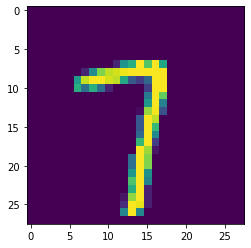

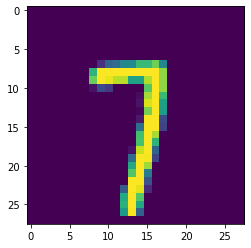

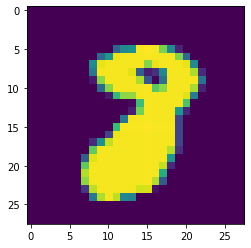

In [34]:
#sample 2 close images and a random one
s1, s2, d = sample_pair(train_loader)
random, _ = next(iter(train_loader))
random = random[0]

#plot images for sanity check
plt.figure(); plt.imshow(s1.squeeze())
plt.figure(); plt.imshow(s2.squeeze())
plt.figure(); plt.imshow(random.squeeze())

#run the model to check the output are expected
print("model output for s1:", model(s1.unsqueeze(0).to(device)).argmax())
print("model output for s2:", model(s2.unsqueeze(0).to(device)).argmax())

In [36]:
print(d)
s1_raw_pattern = get_pattern(model, device, s1.unsqueeze(0))
s2_raw_pattern = get_pattern(model, device, s2.unsqueeze(0))
random_raw_pattern = get_pattern(model, device, random.unsqueeze(0))
layers = ['conv1', 'conv2', 'fc1', 'fc2']

def bit_diff(a, b):
    return np.logical_xor(a, b).sum()
for layer in layers:
    s1_pattern = np.concatenate([s1_raw_pattern[l] for l in [layer]], axis = 1)
    s2_pattern = np.concatenate([s2_raw_pattern[l] for l in [layer]], axis = 1)
    random_pattern = np.concatenate([random_raw_pattern[l] for l in [layer]], axis = 1)
    print("vs s2:", layer, bit_diff(s1_pattern, s2_pattern), "/", len(s1_pattern[0]), bit_diff(s1_pattern, s2_pattern)/len(s1_pattern[0]))
#     print("vs random:",layer, np.logical_xor(s1_pattern, random_pattern).sum(), "/", len(s1_pattern[0]))

tensor(8.1434)
vs s2: conv1 99 / 2704 0.03661242603550296
vs s2: conv2 248 / 4608 0.05381944444444445
vs s2: fc1 1 / 16 0.0625
vs s2: fc2 0 / 10 0.0
